In [1]:
!pip install -U imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler

In [3]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [5]:
df = df.dropna(subset=["description", "points"])

In [6]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


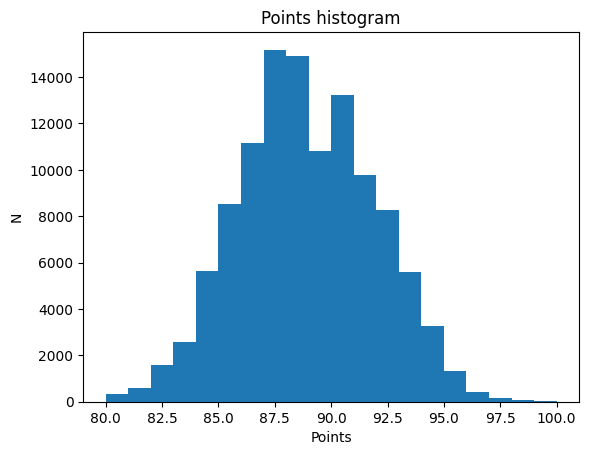

In [7]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [8]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [9]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [11]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [13]:
import tensorflow_hub as hub
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [14]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.38995168, -0.10141923, -0.05818607, ..., -0.05206585,
        -0.08822568, -0.07555018],
       [ 0.2813262 ,  0.12059779, -0.24460077, ..., -0.3466413 ,
        -0.417991  ,  0.01961769],
       [ 0.34363738, -0.24750759, -0.22890675, ...,  0.20278446,
        -0.08354714,  0.10930248],
       ...,
       [ 0.14413951, -0.08786869,  0.06040285, ...,  0.02990566,
        -0.2936783 ,  0.08904526],
       [ 0.5730707 , -0.49529842, -0.06280337, ...,  0.10537624,
         0.02713791,  0.05070394],
       [ 0.34962142, -0.14559212,  0.02830385, ..., -0.06581363,
        -0.30076158, -0.13084847]], dtype=float32)>

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Lambda(lambda x: hub_layer(x)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
model.evaluate(train_data)

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4215 - loss: 0.7035


[0.7036694884300232, 0.41982924938201904]

In [20]:
model.evaluate(valid_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4170 - loss: 0.7033


[0.7034509778022766, 0.41667401790618896]

In [21]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5495 - loss: 0.6954 - val_accuracy: 0.6330 - val_loss: 0.6556
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6220 - loss: 0.6639 - val_accuracy: 0.6329 - val_loss: 0.6414
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6362 - loss: 0.6462 - val_accuracy: 0.6492 - val_loss: 0.6235
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6495 - loss: 0.6319 - val_accuracy: 0.6813 - val_loss: 0.6042
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6616 - loss: 0.6198 - val_accuracy: 0.6910 - val_loss: 0.5928


In [22]:
model.evaluate(test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6860 - loss: 0.5991


[0.6000277996063232, 0.682823657989502]

In [23]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [24]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [25]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [27]:
model.evaluate(train_data)
model.evaluate(valid_data)

89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.4842 - loss: 0.6932
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.4794 - loss: 0.6932


[0.693223237991333, 0.4838283360004425]

In [28]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 439ms/step - accuracy: 0.6434 - loss: 0.6338 - val_accuracy: 0.8155 - val_loss: 0.3986
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 40s 425ms/step - accuracy: 0.8227 - loss: 0.3911 - val_accuracy: 0.8396 - val_loss: 0.3520
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 39s 441ms/step - accuracy: 0.8457 - loss: 0.3492 - val_accuracy: 0.8377 - val_loss: 0.3537
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 39s 432ms/step - accuracy: 0.8482 - loss: 0.3422 - val_accuracy: 0.8422 - val_loss: 0.3472
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 39s 439ms/step - accuracy: 0.8518 - loss: 0.3368 - val_accuracy: 0.8416 - val_loss: 0.3493


In [29]:
model.evaluate(test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.8394 - loss: 0.3457


[0.3456689417362213, 0.8403102159500122]